## 1. Pacakge Load

필요한 패키지들을 로드한다.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.autograd import Function

import torchvision
from torchvision import datasets
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import os
import errno
import argparse
import warnings
import itertools
from PIL import Image

warnings.filterwarnings(action='ignore')

## 2. Set Parameters


In [2]:
parser = argparse.ArgumentParser(description='Pytorch DANN Training')

parser.add_argument('--batch_size', default=32, type=int, help='batch size')
parser.add_argument('--epochs', default=100, type=int, help='number of epoch')
parser.add_argument('--num_workers', default=4, type=int, help='number of workers')

args = parser.parse_args('')

## 3. Load MNIST Dataset

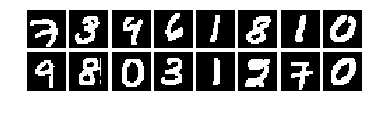

*   **Images**                : Handwritten digits
*   **Labels**                : 0 ~ 9
*   **Shape of Image**        : 1 X 28 X 28 
*   **Number of training set**: 60,000
*   **Number of test set**    : 10,000



In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,)),
            ])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_val   = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test  = datasets.MNIST(root='./data', train=False, transform=transform)


indices = list(range(len(mnist_train)))
val_size = 5000

train_idx, val_idx = indices[val_size:], indices[:val_size]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler   = SubsetRandomSampler(val_idx)


mnist_train_loader = DataLoader(
    dataset=mnist_train,
    batch_size=args.batch_size,
    sampler=train_sampler,
    num_workers=args.num_workers,
)

mnist_val_loader = DataLoader(
    dataset=mnist_val,
    batch_size=args.batch_size,
    sampler=val_sampler,
    num_workers=args.num_workers
)

mnist_test_loader = DataLoader(
    dataset=mnist_test,
    batch_size=args.batch_size,
    num_workers=args.num_workers
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



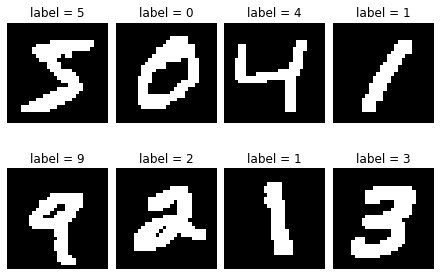

In [4]:
fig, axes = plt.subplots(2, 4, constrained_layout=True)

for i, ax in enumerate(axes.flat):
    ax.imshow(mnist_train.data[i], cmap='gray', vmin=0, vmax=1)
    ax.set(title='label = {}'.format(mnist_train.train_labels[i]))
    ax.set_axis_off()

## 4. Load MNIST-M Dataset

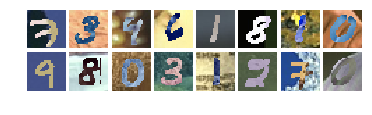


*   **Images** : MNIST digits + BSDS500(randomly extracted as background)
*   **Labels** : 0 ~ 9
*   **Shape of Image** : 3 X 28 X 28
*   **Number of training set** : 60,000
*   **Number of test set** : 10,000




In [5]:
class MNISTM(data.Dataset):
    """`MNIST-M Dataset."""

    url = "https://github.com/VanushVaswani/keras_mnistm/releases/download/1.0/keras_mnistm.pkl.gz"

    raw_folder = 'raw'
    processed_folder = 'processed'
    training_file = 'mnist_m_train.pt'
    test_file = 'mnist_m_test.pt'

    def __init__(self,
                 root, mnist_root="data",
                 train=True,
                 transform=None, target_transform=None,
                 download=False):
        """Init MNIST-M dataset."""
        super(MNISTM, self).__init__()
        self.root = os.path.expanduser(root)
        self.mnist_root = os.path.expanduser(mnist_root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')

        if self.train:
            self.train_data, self.train_labels = \
                torch.load(os.path.join(self.root,
                                        self.processed_folder,
                                        self.training_file))
        else:
            self.test_data, self.test_labels = \
                torch.load(os.path.join(self.root,
                                        self.processed_folder,
                                        self.test_file))

    def __getitem__(self, index):
        """Get images and target for data loader.
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        # print(type(img))
        img = Image.fromarray(img.squeeze().numpy(), mode='RGB')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        """Return size of dataset."""
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)

    def _check_exists(self):
        return os.path.exists(os.path.join(self.root,
                                           self.processed_folder,
                                           self.training_file)) and \
               os.path.exists(os.path.join(self.root,
                                           self.processed_folder,
                                           self.test_file))

    def download(self):
        """Download the MNIST data."""
        # import essential packages
        from six.moves import urllib
        import gzip
        import pickle
        from torchvision import datasets

        # check if dataset already exists
        if self._check_exists():
            return

        # make data dirs
        try:
            os.makedirs(os.path.join(self.root, self.raw_folder))
            os.makedirs(os.path.join(self.root, self.processed_folder))
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

        # download pkl files
        print('Downloading ' + self.url)
        filename = self.url.rpartition('/')[2]
        file_path = os.path.join(self.root, self.raw_folder, filename)
        if not os.path.exists(file_path.replace('.gz', '')):
            data = urllib.request.urlopen(self.url)
            with open(file_path, 'wb') as f:
                f.write(data.read())
            with open(file_path.replace('.gz', ''), 'wb') as out_f, \
                    gzip.GzipFile(file_path) as zip_f:
                out_f.write(zip_f.read())
            os.unlink(file_path)

        # process and save as torch files
        print('Processing...')

        # load MNIST-M images from pkl file
        with open(file_path.replace('.gz', ''), "rb") as f:
            mnist_m_data = pickle.load(f, encoding='bytes')
        mnist_m_train_data = torch.ByteTensor(mnist_m_data[b'train'])
        mnist_m_test_data = torch.ByteTensor(mnist_m_data[b'test'])

        # get MNIST labels
        mnist_train_labels = datasets.MNIST(root=self.mnist_root,
                                            train=True,
                                            download=True).train_labels
        mnist_test_labels = datasets.MNIST(root=self.mnist_root,
                                           train=False,
                                           download=True).test_labels

        # save MNIST-M dataset
        training_set = (mnist_m_train_data, mnist_train_labels)
        test_set = (mnist_m_test_data, mnist_test_labels)
        with open(os.path.join(self.root,
                               self.processed_folder,
                               self.training_file), 'wb') as f:
            torch.save(training_set, f)
        with open(os.path.join(self.root,
                               self.processed_folder,
                               self.test_file), 'wb') as f:
            torch.save(test_set, f)

        print('MNISTM Done!')


transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.29730626, 0.29918741, 0.27534935),
                                                     (0.32780124, 0.32292358, 0.32056796))
            ])

mnistm_train = MNISTM(root='./data/MNISTM', train=True, download=True, transform=transform)
mnistm_val   = MNISTM(root='./data/MNISTM', train=True, download=True, transform=transform)
mnistm_test  = MNISTM(root='./data/MNISTM', train=False, transform=transform)

indices = list(range(len(mnist_train)))
val_size = 5000

train_idx, val_idx = indices[val_size:], indices[:val_size]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler   = SubsetRandomSampler(val_idx)


mnistm_train_loader = DataLoader(
    dataset=mnistm_train,
    batch_size=args.batch_size,
    sampler=train_sampler,
    num_workers=args.num_workers
)

mnistm_val_loader = DataLoader(
    dataset=mnistm_val,
    batch_size=args.batch_size,
    sampler=val_sampler,
    num_workers=args.num_workers
)

mnistm_test_loader = DataLoader(
    dataset=mnistm_test,
    batch_size=args.batch_size,
    num_workers=args.num_workers
)

Processing...
MNISTM Done!


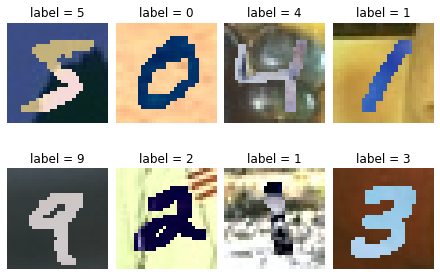

In [6]:
fig, axes = plt.subplots(2, 4, constrained_layout=True)

for i, ax in enumerate(axes.flat):
    ax.imshow(mnistm_train.train_data[i], vmin=0, vmax=1)
    ax.set(title='label = {}'.format(mnistm_train.train_labels[i]))
    ax.set_axis_off()

## 5. Design DANN

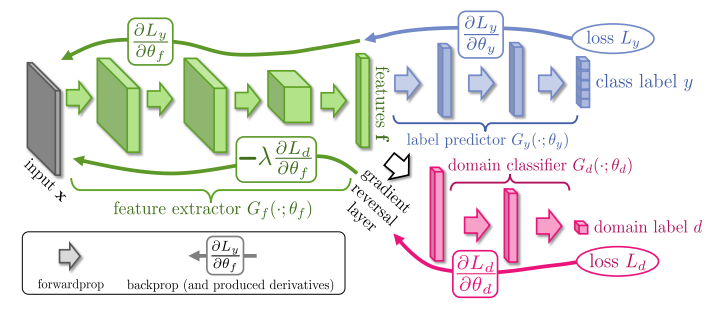

*   **Extractor : Feature extractor (green)**<br/>
Feature extractor $G_f$는 input $x$로부터 feature vector $f$를 추출한다.<br/>
$f = G_f(x; \theta_f)$ <br/><br/>

*   **Classifier : Label predictor (blue)**<br/>
Label predictor $G_y$는 feature vector $f$로부터 label $y$를 예측한다.<br/>
$y = G_y(f; \theta_y)$ <br/><br/>

*   **Discriminator : Domain classifier (red)**<br/>
Domain classifier $G_d$는 feature vector $f$로부터 input $x$의 domain(source or target) $d$를 분류한다. <br/>
$d = G_d(f; \theta_d)$ <br/><br/>

*   **ReverseLayerF : Gradient reversal layer(GRL)**<br/>
GRL은 forward propagation에는 identity transform처럼 동작한다.<br/>
GRL은 backpropagation에는 gradient에 $-\lambda$를 곱한다.<br/>


In [7]:
class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class Extractor(nn.Module):
    def __init__(self):
        super(Extractor, self).__init__()
        self.extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

    def forward(self, x):
        x = self.extractor(x)
        x = x.view(-1, 3 * 28 * 28)
        return x

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=3 * 28 * 28, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=10)
        )

    def forward(self, x):
        x = self.classifier(x)
        return F.softmax(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(in_features=3 * 28 * 28, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=2)
        )

    def forward(self, input_feature, alpha):
        reversed_input = ReverseLayerF.apply(input_feature, alpha)
        x = self.discriminator(reversed_input)
        return F.softmax(x)

## 6. Utility Functions

In [8]:
def optimizer_scheduler(optimizer, p):
    """
    Adjust the learning rate of optimizer
    :param optimizer: optimizer for updating parameters
    :param p: a variable for adjusting learning rate
    :return: optimizer
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.01 / (1. + 10 * p) ** 0.75

    return optimizer


def save_model(encoder, classifier, discriminator, training_mode, save_name):
    print('Save models ...')

    save_folder = 'trained_models'
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    torch.save(encoder.state_dict(), 'trained_models/encoder_' + str(training_mode) + '_' + str(save_name) + '.pt')
    torch.save(classifier.state_dict(), 'trained_models/classifier_' + str(training_mode) + '_' + str(save_name) + '.pt')

    if training_mode == 'dann':
        torch.save(discriminator.state_dict(), 'trained_models/discriminator_' + str(training_mode) + '_' + str(save_name) + '.pt')

    print('Model is saved !!!')


def plot_embedding(X, y, d, training_mode, save_name):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    y = list(itertools.chain.from_iterable(y))
    y = np.asarray(y)

    plt.figure(figsize=(10, 10))
    for i in range(len(d)):  # X.shape[0] : 1024
        # plot colored number
        if d[i] == 0:
            colors = (0.0, 0.0, 1.0, 1.0)
        else:
            colors = (1.0, 0.0, 0.0, 1.0)
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=colors,
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if save_name is not None:
        plt.title(save_name)

    save_folder = 'saved_plot'
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    fig_name = 'saved_plot/' + str(training_mode) + '_' + str(save_name) + '.png'
    plt.savefig(fig_name)
    print('{} is saved'.format(fig_name))


def visualize(encoder, training_mode, save_name):
    # Draw 512 samples in test_data
    source_test_loader = mnist_test_loader
    target_test_loader = mnistm_test_loader

    # Get source_test samples
    source_label_list = []
    source_img_list = []
    for i, test_data in enumerate(source_test_loader):
        if i >= 16:  # to get only 512 samples
            break
        img, label = test_data
        label = label.numpy()
        img = img.cuda()
        img = torch.cat((img, img, img), 1)  # MNIST channel 1 -> 3
        source_label_list.append(label)
        source_img_list.append(img)

    source_img_list = torch.stack(source_img_list)
    source_img_list = source_img_list.view(-1, 3, 28, 28)

    # Get target_test samples
    target_label_list = []
    target_img_list = []
    for i, test_data in enumerate(target_test_loader):
        if i >= 16:
            break
        img, label = test_data
        label = label.numpy()
        img = img.cuda()
        target_label_list.append(label)
        target_img_list.append(img)

    target_img_list = torch.stack(target_img_list)
    target_img_list = target_img_list.view(-1, 3, 28, 28)

    # Stack source_list + target_list
    combined_label_list = source_label_list
    combined_label_list.extend(target_label_list)
    combined_img_list = torch.cat((source_img_list, target_img_list), 0)

    source_domain_list = torch.zeros(512).type(torch.LongTensor)
    target_domain_list = torch.ones(512).type(torch.LongTensor)
    combined_domain_list = torch.cat((source_domain_list, target_domain_list), 0).cuda()

    print("Extract features to draw T-SNE plot...")
    combined_feature = encoder(combined_img_list)  # combined_feature : 1024,2352

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
    dann_tsne = tsne.fit_transform(combined_feature.detach().cpu().numpy())

    print('Draw plot ...')
    save_name = save_name + '_' + str(training_mode)
    plot_embedding(dann_tsne, combined_label_list, combined_domain_list, training_mode, save_name)


def get_free_gpu():
    os.system('nvidia-smi -q -d Memory |grep -A4 GPU|grep Free >tmp')
    memory_available = [int(x.split()[2]) for x in open('tmp', 'r').readlines()]
    return np.argmax(memory_available)


def set_model_mode(mode='train', models=None):
    for model in models:
        if mode == 'train':
            model.train()
        else:
            model.eval()

## 7. Test

* **Tester : Test function**
    * Source domain으로부터 학습된 model에 대한 성능을 측정하는 function이다.
    * Source only로 학습된 경우 source domain과 target domain의 accuracy를 측정한다.
    * DANN으로 학습된 경우 source domain과 target domain, domain label에 대한 accuracy를 측정한다.


In [9]:
def tester(encoder, classifier, discriminator, source_test_loader, target_test_loader, training_mode):
    print('Model test ...')

    encoder.cuda()
    classifier.cuda()
    set_model_mode('eval', [encoder, classifier])

    if training_mode == 'dann':
        discriminator.cuda()
        set_model_mode('eval', [discriminator])
        domain_correct = 0

    source_correct = 0
    target_correct = 0

    for batch_idx, (source_data, target_data) in enumerate(zip(source_test_loader, target_test_loader)):
        p = float(batch_idx) / len(source_test_loader)
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        # 1. Source input -> Source Classification
        source_image, source_label = source_data
        source_image, source_label = source_image.cuda(), source_label.cuda()
        source_image = torch.cat((source_image, source_image, source_image), 1)  # MNIST convert to 3 channel
        source_feature = encoder(source_image)
        source_output = classifier(source_feature)
        source_pred = source_output.data.max(1, keepdim=True)[1]
        source_correct += source_pred.eq(source_label.data.view_as(source_pred)).cpu().sum()

        # 2. Target input -> Target Classification
        target_image, target_label = target_data
        target_image, target_label = target_image.cuda(), target_label.cuda()
        target_feature = encoder(target_image)
        target_output = classifier(target_feature)
        target_pred = target_output.data.max(1, keepdim=True)[1]
        target_correct += target_pred.eq(target_label.data.view_as(target_pred)).cpu().sum()

        if training_mode == 'dann':
            # 3. Combined input -> Domain Classificaion
            combined_image = torch.cat((source_image, target_image), 0)  # 64 = (S:32 + T:32)
            domain_source_labels = torch.zeros(source_label.shape[0]).type(torch.LongTensor)
            domain_target_labels = torch.ones(target_label.shape[0]).type(torch.LongTensor)
            domain_combined_label = torch.cat((domain_source_labels, domain_target_labels), 0).cuda()
            domain_feature = encoder(combined_image)
            domain_output = discriminator(domain_feature, alpha)
            domain_pred = domain_output.data.max(1, keepdim=True)[1]
            domain_correct += domain_pred.eq(domain_combined_label.data.view_as(domain_pred)).cpu().sum()

    if training_mode == 'dann':
        print("Test Results on DANN :")
        print('\nSource Accuracy: {}/{} ({:.2f}%)\n'
              'Target Accuracy: {}/{} ({:.2f}%)\n'
              'Domain Accuracy: {}/{} ({:.2f}%)\n'.
            format(
            source_correct, len(source_test_loader.dataset), 100. * source_correct.item() / len(source_test_loader.dataset),
            target_correct, len(target_test_loader.dataset), 100. * target_correct.item() / len(target_test_loader.dataset),
            domain_correct, len(source_test_loader.dataset) + len(target_test_loader.dataset), 100. * domain_correct.item() / (len(source_test_loader.dataset) + len(target_test_loader.dataset))
        ))
    else:
        print("Test results on source_only :")
        print('\nSource Accuracy: {}/{} ({:.2f}%)\n'
              'Target Accuracy: {}/{} ({:.2f}%)\n'.format(
            source_correct, len(source_test_loader.dataset), 100. * source_correct.item() / len(source_test_loader.dataset),
            target_correct, len(target_test_loader.dataset), 100. * target_correct.item() / len(target_test_loader.dataset)))

## 7. Train

* **Loss for label prediction** <br/>
$L_y(G_y(G_f(x_i; \theta_f); \theta_y), y_i)$ <br/><br/>

* **Loss for domain classification** <br/>
$L_d(G_d(G_f(x_i; \theta_f); \theta_d), y_i)$ <br/><br/>

* **Optimization with backpropagation** <br/>
$\theta_f \leftarrow \theta_f - \mu (\frac{\partial L_y^i}{\partial \theta_f} - \lambda \frac{\partial L_d^i}{\partial \theta_f})$ <br/><br/>

---

* **source_only**
    * Source domain만을 통해 학습하는 train function이다.

* **dann**
    * Domain adaptation을 통해 학습하는 train function이다.

In [10]:
# Source : 0, Target :1
source_test_loader = mnist_test_loader
target_test_loader = mnistm_test_loader


def source_only(encoder, classifier, source_train_loader, target_train_loader, save_name):
    print("Source-only training")
    classifier_criterion = nn.CrossEntropyLoss().cuda()
    optimizer = optim.SGD(
        list(encoder.parameters()) +
        list(classifier.parameters()),
        lr=0.01, momentum=0.9)
    
    for epoch in range(args.epochs):
        print('Epoch : {}'.format(epoch))
        set_model_mode('train', [encoder, classifier])

        start_steps = epoch * len(source_train_loader)
        total_steps = args.epochs * len(target_train_loader)
        
        for batch_idx, (source_data, target_data) in enumerate(zip(source_train_loader, target_train_loader)):
            source_image, source_label = source_data
            p = float(batch_idx + start_steps) / total_steps

            source_image = torch.cat((source_image, source_image, source_image), 1)  # MNIST convert to 3 channel
            source_image, source_label = source_image.cuda(), source_label.cuda()  # 32

            optimizer = optimizer_scheduler(optimizer=optimizer, p=p)
            optimizer.zero_grad()

            source_feature = encoder(source_image)

            # Classification loss
            class_pred = classifier(source_feature)
            class_loss = classifier_criterion(class_pred, source_label)

            class_loss.backward()
            optimizer.step()
            if (batch_idx + 1) % 50 == 0:
                print('[{}/{} ({:.0f}%)]\tClass Loss: {:.6f}'.format(batch_idx * len(source_image), len(source_train_loader.dataset), 100. * batch_idx / len(source_train_loader), class_loss.item()))

        if (epoch + 1) % 10 == 0:
            tester(encoder, classifier, None, source_test_loader, target_test_loader, training_mode='source_only')
    save_model(encoder, classifier, None, 'source_only', save_name)
    visualize(encoder, 'source_only', save_name)


def dann(encoder, classifier, discriminator, source_train_loader, target_train_loader, save_name):
    print("DANN training")
    
    classifier_criterion = nn.CrossEntropyLoss().cuda()
    discriminator_criterion = nn.CrossEntropyLoss().cuda()
    
    optimizer = optim.SGD(
    list(encoder.parameters()) +
    list(classifier.parameters()) +
    list(discriminator.parameters()),
    lr=0.01,
    momentum=0.9)
    
    for epoch in range(args.epochs):
        print('Epoch : {}'.format(epoch))
        set_model_mode('train', [encoder, classifier, discriminator])

        start_steps = epoch * len(source_train_loader)
        total_steps = args.epochs * len(target_train_loader)
        
        for batch_idx, (source_data, target_data) in enumerate(zip(source_train_loader, target_train_loader)):

            source_image, source_label = source_data
            target_image, target_label = target_data

            p = float(batch_idx + start_steps) / total_steps
            alpha = 2. / (1. + np.exp(-10 * p)) - 1

            source_image = torch.cat((source_image, source_image, source_image), 1)

            source_image, source_label = source_image.cuda(), source_label.cuda()
            target_image, target_label = target_image.cuda(), target_label.cuda()
            combined_image = torch.cat((source_image, target_image), 0)

            optimizer = optimizer_scheduler(optimizer=optimizer, p=p)
            optimizer.zero_grad()

            combined_feature = encoder(combined_image)
            source_feature = encoder(source_image)

            # 1.Classification loss
            class_pred = classifier(source_feature)
            class_loss = classifier_criterion(class_pred, source_label)

            # 2. Domain loss
            domain_pred = discriminator(combined_feature, alpha)

            domain_source_labels = torch.zeros(source_label.shape[0]).type(torch.LongTensor)
            domain_target_labels = torch.ones(target_label.shape[0]).type(torch.LongTensor)
            domain_combined_label = torch.cat((domain_source_labels, domain_target_labels), 0).cuda()
            domain_loss = discriminator_criterion(domain_pred, domain_combined_label)

            total_loss = class_loss + domain_loss
            total_loss.backward()
            optimizer.step()

            if (batch_idx + 1) % 50 == 0:
                print('[{}/{} ({:.0f}%)]\tLoss: {:.6f}\tClass Loss: {:.6f}\tDomain Loss: {:.6f}'.format(
                    batch_idx * len(target_image), len(target_train_loader.dataset), 100. * batch_idx / len(target_train_loader), total_loss.item(), class_loss.item(), domain_loss.item()))

        if (epoch + 1) % 10 == 0:
            tester(encoder, classifier, discriminator, source_test_loader, target_test_loader, training_mode='dann')

    save_model(encoder, classifier, discriminator, 'dann', save_name)
    visualize(encoder, 'dann', save_name)

## 8. Main

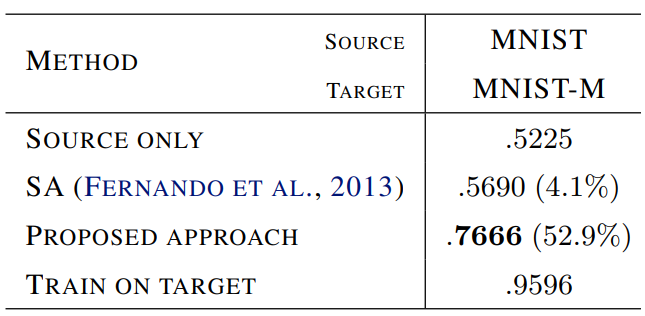

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[7968/60000 (14%)]	Class Loss: 1.461153
[9568/60000 (17%)]	Class Loss: 1.461166
[11168/60000 (20%)]	Class Loss: 1.492401
[12768/60000 (23%)]	Class Loss: 1.461151
[14368/60000 (26%)]	Class Loss: 1.461153
[15968/60000 (29%)]	Class Loss: 1.461151
[17568/60000 (32%)]	Class Loss: 1.461151
[19168/60000 (35%)]	Class Loss: 1.461214
[20768/60000 (38%)]	Class Loss: 1.461151
[22368/60000 (41%)]	Class Loss: 1.461151
[23968/60000 (44%)]	Class Loss: 1.461158
[25568/60000 (46%)]	Class Loss: 1.461151
[27168/60000 (49%)]	Class Loss: 1.461183
[28768/60000 (52%)]	Class Loss: 1.461162
[30368/60000 (55%)]	Class Loss: 1.461151
[31968/60000 (58%)]	Class Loss: 1.461151
[33568/60000 (61%)]	Class Loss: 1.461151
[35168/60000 (64%)]	Class Loss: 1.461151
[36768/60000 (67%)]	Class Loss: 1.461152
[38368/60000 (70%)]	Class Loss: 1.461151
[39968/60000 (73%)]	Class Loss: 1.461151
[41568/60000 (76%)]	Class Loss: 1.461151
[43168/60000 (78%)]	Class Loss: 1.492401
[44768/60000 (81%)]	Cla

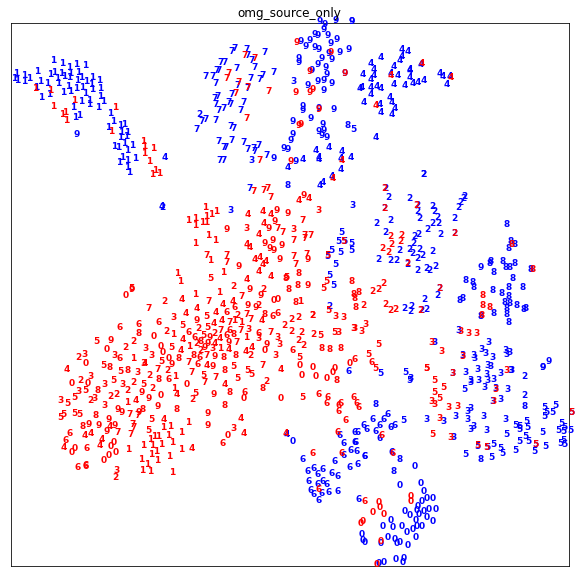

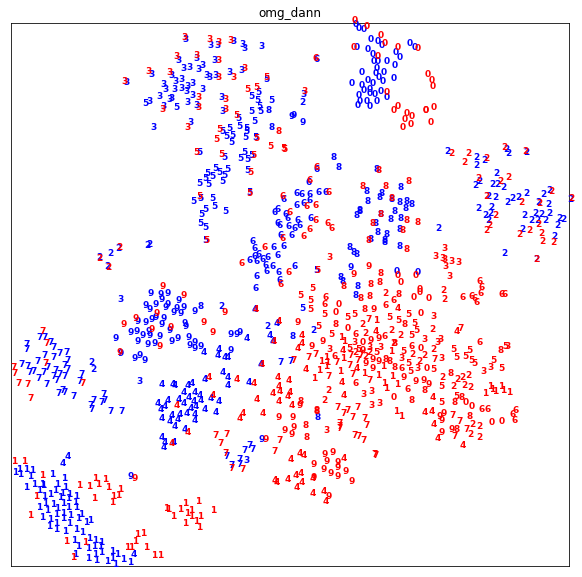

In [11]:
save_name = 'omg'


def main():
    source_train_loader = mnist_train_loader
    target_train_loader = mnistm_train_loader

    if torch.cuda.is_available():
        get_free_gpu()
        print('Running GPU : {}'.format(torch.cuda.current_device()))
        encoder = Extractor().cuda()
        classifier = Classifier().cuda()
        discriminator = Discriminator().cuda()

        source_only(encoder, classifier, source_train_loader, target_train_loader, save_name)
        dann(encoder, classifier, discriminator, source_train_loader, target_train_loader, save_name)

    else:
        print("There is no GPU -_-!")


if __name__ == "__main__":
    main()